Saved figure: /Users/fransiskusbudi/UoE/Dissertation/multimodal_segmentation_project/results/line_ct_vs_mri_avg_dice_dann_add.png


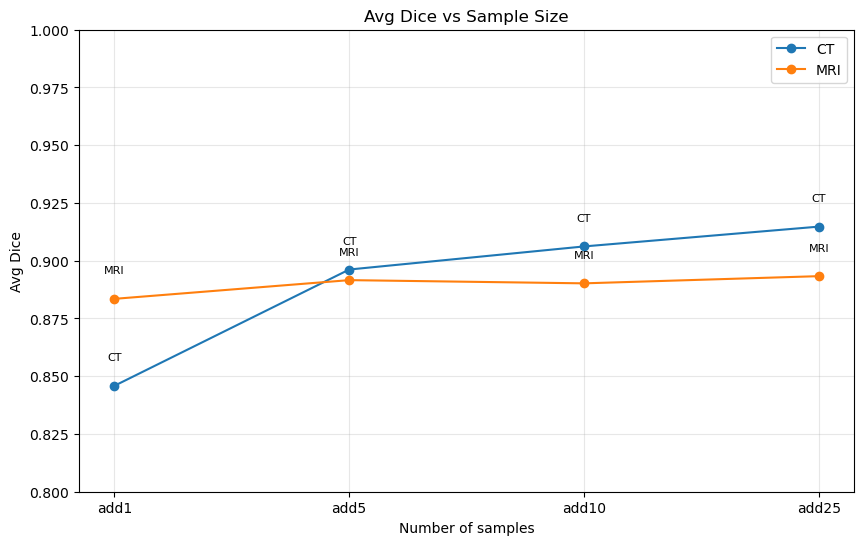

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- config ----------------
# Path to Excel (relative to this notebook's folder)
XLSX_PATH = os.path.join("..", "results", "dann_add.xlsx")

# Metric to plot on Y-axis
METRIC = "avg_dice"   # e.g., "avg_dice", "dice_spleen", "dice_liver", "dice_kidneys"

# Y-axis range (adjust as you like; values are clamped to [0,1] after padding)
Y_MIN = 0.8
Y_MAX = 1.0

# Save figure into the same folder as the Excel file
SAVE_IN_RESULTS_FOLDER = True
# ----------------------------------------

def infer_modality_from_experiment(exp: str) -> str:
    s = str(exp).lower()
    tokens = s.split("_")
    if "ct" in tokens:
        return "CT"
    if "mri" in tokens:
        return "MRI"
    if "_ct_" in s or s.startswith("ct_"):
        return "CT"
    if "_mri_" in s or s.startswith("mri_"):
        return "MRI"
    return "Unknown"

def infer_sample_label(exp: str) -> str:
    """Extracts sample label for x-axis.
    Priority:
    1. If contains 'add<number>' → return 'add<number>'
    2. Else, normal n/ns pattern → return 'n<number>'
    """
    s = str(exp).lower()

    # Check for add<number>
    m = re.search(r'(?:^|_)add(\d+)', s)
    if m:
        return f"add{m.group(1)}"

    # Check for n / ns<number>
    m = re.search(r'(?:^|_)(n?s)(\d+)', s)
    if m:
        return f"n{m.group(2)}"

    # Fallback: _n<number>
    m = re.search(r'(?:^|_)n(\d+)', s)
    if m:
        return f"n{m.group(1)}"

    return "?"


# Load data
df = pd.read_excel(XLSX_PATH)

# Basic checks
if METRIC not in df.columns:
    raise ValueError(
        f"Metric '{METRIC}' not found in Excel. "
        f"Available columns include: {', '.join(df.columns)}"
    )

# Infer modality and sample size from experiment name
df["modality"] = df["experiment"].apply(infer_modality_from_experiment)
df["n_label"] = df["experiment"].apply(infer_sample_label)

# Keep only CT / MRI rows
df = df[df["modality"].isin(["CT", "MRI"])].copy()

# Aggregate by (n_label, modality)
summary = (
    df.groupby(["n_label", "modality"])[METRIC]
      .agg(["mean", "std", "count"])
      .reset_index()
)

# Sort x-axis by numeric part of n_label
def n_key(label: str) -> float:
    """Sort key for x-axis labels.
    Handles 'add<number>' and 'n<number>' numerically.
    """
    label = str(label).lower()
    # Handle add<number>
    if label.startswith("add"):
        m = re.search(r'add(\d+)', label)
        if m:
            return float(m.group(1))  # could use small offset if mixing add/n
    # Handle n<number>
    if label.startswith("n"):
        m = re.search(r'n(\d+)', label)
        if m:
            return float(m.group(1)) + 1000  # offset to place after addXX if mixed
    return float("inf")


x_order = sorted(summary["n_label"].unique(), key=n_key)
summary["n_label"] = pd.Categorical(summary["n_label"], categories=x_order, ordered=True)
summary = summary.sort_values(["n_label", "modality"])

# Pivot to arrays for plotting
pivot_mean = summary.pivot(index="n_label", columns="modality", values="mean").reindex(x_order)

# X ticks
x_ticks = list(range(len(x_order)))

# Get series
ct_y = pivot_mean["CT"].values if "CT" in pivot_mean.columns else None
mri_y = pivot_mean["MRI"].values if "MRI" in pivot_mean.columns else None

# Plot
plt.figure(figsize=(10, 6))

if ct_y is not None:
    plt.plot(x_ticks, ct_y, marker="o", label="CT")
if mri_y is not None:
    plt.plot(x_ticks, mri_y, marker="o", label="MRI")

# Annotate each point with modality (no counts)
for idx, xlab in enumerate(x_order):
    if ct_y is not None and not pd.isna(ct_y[idx]):
        plt.text(idx, ct_y[idx] + 0.01, "CT", ha="center", va="bottom", fontsize=8)
    if mri_y is not None and not pd.isna(mri_y[idx]):
        plt.text(idx, mri_y[idx] + 0.01, "MRI", ha="center", va="bottom", fontsize=8)

plt.xticks(ticks=x_ticks, labels=x_order)

# Clamp y-range within [0, 1] but allow manual override
ymin = max(0.0, float(Y_MIN))
ymax = min(1.0, float(Y_MAX))
if ymin >= ymax:
    ymin, ymax = 0.0, 1.0
plt.ylim(ymin, ymax)

plt.xlabel("Number of samples")
plt.ylabel(METRIC.replace("_", " ").title())
plt.title(f"{METRIC.replace('_', ' ').title()} vs Sample Size")
plt.legend()
plt.grid(alpha=0.3)

# Save figure
base = os.path.splitext(os.path.basename(XLSX_PATH))[0]
out_name = f"line_ct_vs_mri_{METRIC}_{base}.png"
if SAVE_IN_RESULTS_FOLDER:
    out_dir = os.path.dirname(os.path.abspath(XLSX_PATH))
else:
    out_dir = os.getcwd()

os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, out_name)
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved figure: {out_path}")
plt.show()


Saved figure: /Users/fransiskusbudi/UoE/Dissertation/multimodal_segmentation_project/results/line_ct_vs_mri_avg_dice_dann.png


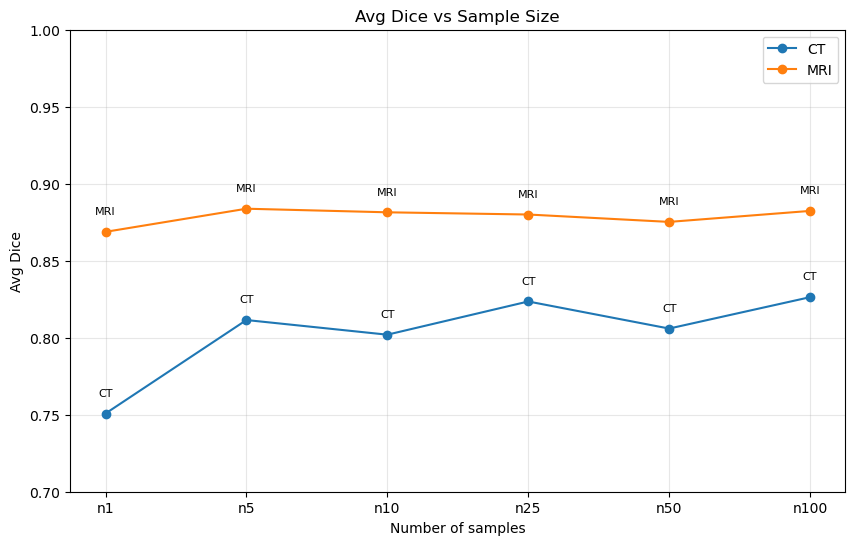

In [23]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- config ----------------
# Path to Excel (relative to this notebook's folder)
XLSX_PATH = os.path.join("..", "results", "dann.xlsx")

# Metric to plot on Y-axis
METRIC = "avg_dice"   # e.g., "avg_dice", "dice_spleen", "dice_liver", "dice_kidneys"

# Y-axis range (adjust as you like; values are clamped to [0,1] after padding)
Y_MIN = 0.7
Y_MAX = 1.0

# Save figure into the same folder as the Excel file
SAVE_IN_RESULTS_FOLDER = True
# ----------------------------------------

def infer_modality_from_experiment(exp: str) -> str:
    s = str(exp).lower()
    tokens = s.split("_")
    if "ct" in tokens:
        return "CT"
    if "mri" in tokens:
        return "MRI"
    if "_ct_" in s or s.startswith("ct_"):
        return "CT"
    if "_mri_" in s or s.startswith("mri_"):
        return "MRI"
    return "Unknown"

def infer_sample_label(exp: str) -> str:
    """Extract sample-size token as 'n<number>' from experiment name.
    Handles 'n100', 'ns100', 'n50', 'n25', etc. Normalizes 'ns100' -> 'n100'.
    """
    s = str(exp).lower()
    m = re.search(r'(?:^|_)(n?s)(\d+)', s)
    if m:
        return f"n{m.group(2)}"
    m = re.search(r'(?:^|_)n(\d+)', s)
    if m:
        return f"n{m.group(1)}"
    return "n?"

# Load data
df = pd.read_excel(XLSX_PATH)

# Basic checks
if METRIC not in df.columns:
    raise ValueError(
        f"Metric '{METRIC}' not found in Excel. "
        f"Available columns include: {', '.join(df.columns)}"
    )

# Infer modality and sample size from experiment name
df["modality"] = df["experiment"].apply(infer_modality_from_experiment)
df["n_label"] = df["experiment"].apply(infer_sample_label)

# Keep only CT / MRI rows
df = df[df["modality"].isin(["CT", "MRI"])].copy()

# Aggregate by (n_label, modality)
summary = (
    df.groupby(["n_label", "modality"])[METRIC]
      .agg(["mean", "std", "count"])
      .reset_index()
)

# Sort x-axis by numeric part of n_label
def n_key(nlabel: str) -> int:
    m = re.search(r'n(\d+)', str(nlabel).lower())
    return int(m.group(1)) if m else 0

x_order = sorted(summary["n_label"].unique(), key=n_key)
summary["n_label"] = pd.Categorical(summary["n_label"], categories=x_order, ordered=True)
summary = summary.sort_values(["n_label", "modality"])

# Pivot to arrays for plotting
pivot_mean = summary.pivot(index="n_label", columns="modality", values="mean").reindex(x_order)

# X ticks
x_ticks = list(range(len(x_order)))

# Get series
ct_y = pivot_mean["CT"].values if "CT" in pivot_mean.columns else None
mri_y = pivot_mean["MRI"].values if "MRI" in pivot_mean.columns else None

# Plot
plt.figure(figsize=(10, 6))

if ct_y is not None:
    plt.plot(x_ticks, ct_y, marker="o", label="CT")
if mri_y is not None:
    plt.plot(x_ticks, mri_y, marker="o", label="MRI")

# Annotate each point with modality (no counts)
for idx, xlab in enumerate(x_order):
    if ct_y is not None and not pd.isna(ct_y[idx]):
        plt.text(idx, ct_y[idx] + 0.01, "CT", ha="center", va="bottom", fontsize=8)
    if mri_y is not None and not pd.isna(mri_y[idx]):
        plt.text(idx, mri_y[idx] + 0.01, "MRI", ha="center", va="bottom", fontsize=8)

plt.xticks(ticks=x_ticks, labels=x_order)

# Clamp y-range within [0, 1] but allow manual override
ymin = max(0.0, float(Y_MIN))
ymax = min(1.0, float(Y_MAX))
if ymin >= ymax:
    ymin, ymax = 0.0, 1.0
plt.ylim(ymin, ymax)

plt.xlabel("Number of samples")
plt.ylabel(METRIC.replace("_", " ").title())
plt.title(f"{METRIC.replace('_', ' ').title()} vs Sample Size")
plt.legend()
plt.grid(alpha=0.3)

# Save figure
base = os.path.splitext(os.path.basename(XLSX_PATH))[0]
out_name = f"line_ct_vs_mri_{METRIC}_{base}.png"
if SAVE_IN_RESULTS_FOLDER:
    out_dir = os.path.dirname(os.path.abspath(XLSX_PATH))
else:
    out_dir = os.getcwd()

os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, out_name)
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved figure: {out_path}")
plt.show()